# Stylized Chinese Characters

### An EE 379K Term Project

Written and Completed by: Wenyang Fu, Leelabrindavanan Karunakaran, Rohan Nagar

In [2]:
from IPython.display import Image, HTML, display
from glob import glob

## Motivation

With thousands of Chinese Characters, creating a new font style is a difficult task. What if, instead of creating each character in that font by hand, a designer could design just a few characters and let a machine learn the rest? This is the motivation behind our project.

We began with work from Yuchen Tian, who has recently written code to attempt to tackle this problem [https://github.com/kaonashi-tyc/Rewrite]. This is written in Python using Tensorflow, and we attempted to train his neural network models locally. We ran into many problems doing this, and we will detail each one.

### Memory Issues

The first problem was running out of memory. We used Docker to contain our enviornment, and initally provided it with 2GB of RAM. When attempting to train the model, it would eventually fail with an OutOfMemoryError. We noticed that the implementation uses leaky relus, and also found this issue in Tensorflow's implementation titled 'LeakyReLU uses up too much memory': https://github.com/tensorflow/tensorflow/issues/4079. We will dicuss the Leaky ReLU activation function later.

### CPU Runtime

After increasing the memory available for our containers, we began to train the network locally, on our CPUs. This proved to be an almost impossible task. After 3 hours, the network went through 10 iterations. By our calculations, this would take 18 days to train over 3000 iterations, which is the recommended number of iterations by the author.

### Attempt to Acquire GPU

We wanted to attempt to train this network on a GPU using Amazon Web Services. However, we were unable to launch a P-Series EC2 instance (an instance with GPU capabilities) due to restrictions from Amazon. They require an approval process to use a GPU instance.

We then attempted to use Microsoft's Azure. Their GPU instances were released to the public yesterday, December 1st. However, their free-tier restriction is that you can only have 4 cores across all instances. The GPU instances have 6 cores at a minimum - 4 CPU and 2 GPU.

Finally, we attempted to use IBM Bluemix. However, their GPU servers are only rented per month, and the cost was too high (roughly $1000 per month).

So, we were unable to attempt to train the model on a GPU, which seems to be necessary.

## What Worked

What we ended up settling on is training the model with 8 GB RAM and 7/8 cores on Leela's CPU. This has been running for a long time, and is starting to see some results. We explore and describe these below, but first let's talk about the implementation.

## Implementation

The implementation uses a top-down CNN structure. This network structure is shown below. The varying size of convolutional layers allows the network to capture details at different levels. Each convolutional layer is followed by a batch normalization layer and then a ReLU layer, which we describe below.

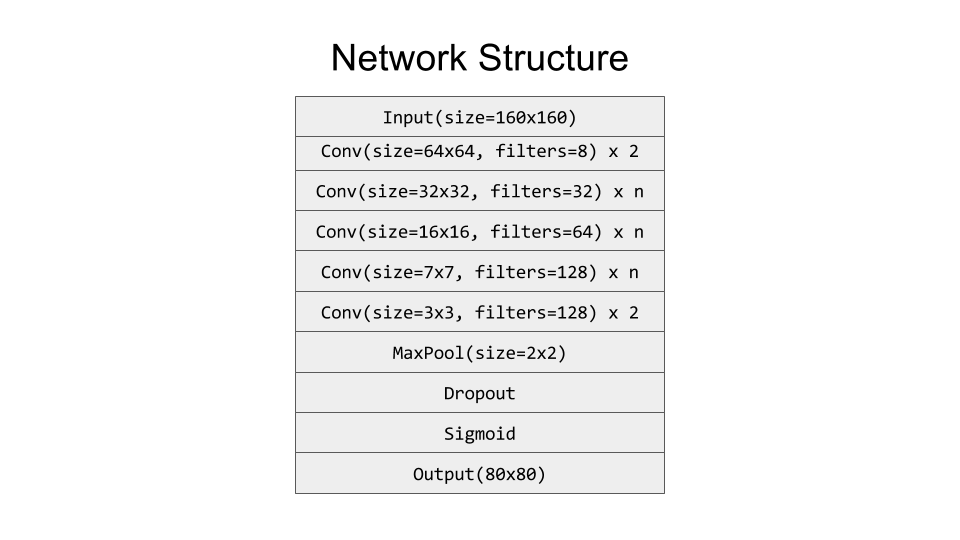

In [2]:
Image(filename='implementation/structure.png')

### Leaky ReLU

We want to describe Leaky ReLU since this is what was causing memory problems for us early on.

ReLU is an activiation function that stands for Rectified Linear Unit. It computes the function $f(x) = max(0,x)$. In other words, the activation is thresholded at zero. This can be seen in the graph below.

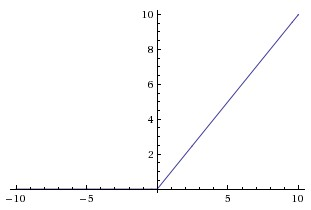

In [3]:
Image(filename='graphs/relu.jpeg')

Unfortunately, ReLU units can be fragile during training and can “die”. For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero. If the learning rate is set too high, it is possible that up to 40% of the network could be "dead".

Leaky ReLU is an attempt to fix this problem. Instead of the function being zero when x < 0, a leaky ReLU will instead have a small negative slope (of 0.01, or so). That is, the function computes $f(x)=𝟙(x<0)(αx)+𝟙(x>=0)(x)$ where α is a small constant.

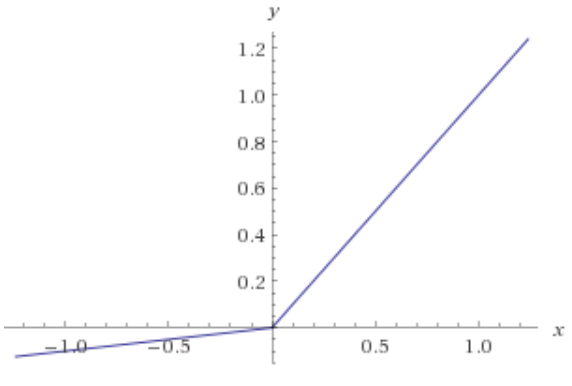

In [4]:
Image(filename='graphs/leaky_relu.png')

### Loss Function

The loss function used is a weighted loss. It is a sum of the absolute pixel loss and the total variation loss.

The absolute pixel loss is calculated by first generating a Chinese character and comparing to the ground truth target font. The loss is just how many pixels differ between these two images.

The total variation loss is used to regularize image smoothness. Total variation denoising focuses on noise removal in images and is often used in digital image processing. The total variation can be defined as

$$
\sum_{i,j} |y_{i+1,j} - y_{i,j}| + |y_{i,j+1} - y_{i,j}|
$$

Again, these loss functions are used together and their combination is minimized. Using this loss funciton was inspired by previous papers on neural style transfer networks.

We can think of a reason why the absolute pixel loss may be a bad loss function. For example, assume that we are attempting to generate the number 9 in a certain font. It could generate it in multiple ways, but for our example say that it could generate one in a bold font and missing the stem of the 9, and the other in a less bold font but a complete 9. With the absolute pixel loss, the loss of both of these would be the same. However, clearly one image is better than the other! This means that a font could look better but could also have a higher loss.

Changing this loss function would be something to experiment with in the future. Is there loss function to capture more granularity?

## Results

From running the code on the CPU, we were able to start getting some preliminary results in the time that we had. These frames are shown below, and we can see that over time the characters are starting to take shape. Each image displayed is after 10 more steps.

We start with a standard look font, SIMSUN [https://www.microsoft.com/typography/Fonts/family.aspx?FID=37] and attempt to learn a stylized font from this webpage [https://chinesefontdesign.com/tag/simplified-chinese-font]. We chose a bold font to attempt to learn.

In [3]:
imagesList=''.join( ["<img style='width: 440px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in sorted(glob('container_notebooks/frames/step_*.png')) ])
display(HTML(imagesList))

## Our Additional Attempts

In order to work within our memory (and time) constraints, we decided to try out another implementation where we take the VGG16 network and modify it for transfer learning. We tried to port the loss function from the existing implementation to this model. However, we ran into a problem when attempting this.

The loss function from the existing implementation expects the image sizes to be a certain size in order to compute the absolute pixel difference. However, the VGG16 network uses max pooling on the images so that outputs are eventually smaller. This means that we can't use this network since the images will be smaller than 80x80.

We then wanted to look for an alternative way to do transfer learning and we settled on Keras' neural style transfer beacuase their loss function is different. They use a combination of mean squared error, total variation loss, and a style loss using the Gram Matrix. Since this loss does not include an absolute pixel difference, we are okay to train.

We were able to write code to train the Keras neural style transfer network using numpy arrays of the font images.